In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import sys
%matplotlib inline
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
# Importing everything from forecasting quality metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VECM

In [2]:
# Load the dataset scraped from ENTSOE
def get_columns(df):
    return df.columns
    
def find_time_col(df):
    for column in get_columns(df):
        try:

            found = datetime.strptime(df[column][0][:10], '%d.%m.%Y')

            return column
        except:
            continue
            
            

directory = os.getcwd() + "/download/"
file_names = os.listdir(directory)
for i in range(0, len(file_names)):
    if i==0:
        df = pd.read_csv(directory + file_names[i])
        # reformat time
        column = find_time_col(df)
        #print(df)
        df['col_index'] = df[column].replace('\ -(.*)', '', regex=True)
        df['col_index'] = pd.to_datetime(df['col_index'], format = '%d.%m.%Y %H:%M')
        df = df.rename(columns={'col_index':'time_column'})
        df = df.set_index(df['time_column'])
        df = df.drop(columns = df.columns[[0,2]])
        
        # convert all columns to numeric
        for column in get_columns(df):
            df[column] = pd.to_numeric(df[column], errors = 'coerce')
        print(df)
        # remove all the first duplicates
        df.drop_duplicates(keep='first', inplace = True)
        
        # Drop all the time column
        #df = df.drop(columns = 'time_column')
        
        # resample if quarter hourly to Hourly
        if ("Actual" or "Load" or "Forecasts") in file_names[i]:
            df = df.resample('H').mean()
        
    else:
        df2 = pd.read_csv(directory + file_names[i])

        # reformat time
        column = find_time_col(df2)
        df2['col_index'] = df2[column].replace('\ -(.*)', '', regex=True)
        df2['col_index'] = pd.to_datetime(df2['col_index'], format = '%d.%m.%Y %H:%M')
        df2 = df2.rename(columns={'col_index':'time_column'})

        df2 = df2.set_index(df2['time_column'])
        #df = df.drop(columns = df.columns[[0,2]])

        
        # convert all columns to numeric
        for column in get_columns(df2):
            df2[column] = pd.to_numeric(df2[column], errors='coerce')
        # remove all the first duplicates
        df2.drop_duplicates(keep='first', inplace = True)

        
        
        # Drop all the columns that are not numeric
        for column in get_columns(df2):
            try:
                float(df2[column])
            except:
                df2.drop(columns = [column])
                continue
                
        # convert all the non-numeric values to NAN using coerce 
        for column in get_columns(df2):
            try:
                df2[column] = pd.to_numeric(df2[column], errors = 'coerce')
            except:
                print('Cannot get the columns!')
        
        
        # Drop all the time column
        #df = df.drop(columns = {'time_column'})
        
        #df2 = df2.resample('1H').mean()
        df2 = df2.resample('H').mean()
            
        # concatenate all the columns in one single dataset  
        df = pd.concat([df, df2], axis=1, sort ='False')
        
    

                     Day-ahead Price [EUR/MWh]
time_column                                   
2020-01-01 00:00:00                      41.88
2020-01-01 01:00:00                      38.60
2020-01-01 02:00:00                      36.55
2020-01-01 03:00:00                      32.32
2020-01-01 04:00:00                      30.85
...                                        ...
2020-12-31 19:00:00                        NaN
2020-12-31 20:00:00                        NaN
2020-12-31 21:00:00                        NaN
2020-12-31 22:00:00                        NaN
2020-12-31 23:00:00                        NaN

[8785 rows x 1 columns]


/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3,5,6,7,10,11,12,13,14,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df

,Day-ahead Price [EUR/MWh],Area,MTU,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],...,Generation - Solar [MW] Day Ahead/ BZN|DE-LU,Generation - Solar [MW] Intraday / BZN|DE-LU,Generation - Solar [MW] Current / BZN|DE-LU,Generation - Wind Offshore [MW] Day Ahead/ BZN|DE-LU,Generation - Wind Offshore [MW] Intraday / BZN|DE-LU,Generation - Wind Offshore [MW] Current / BZN|DE-LU,Generation - Wind Onshore [MW] Day Ahead/ BZN|DE-LU,Generation - Wind Onshore [MW] Intraday / BZN|DE-LU,Generation - Wind Onshore [MW] Current / BZN|DE-LU,time_column
time_column,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,41.88,NaN,NaN,4861.50,9317.00,NaN,4916.50,1961.75,454.00,NaN,...,0.0,0.0,NaN,723.50,577.50,NaN,5781.00,6061.00,NaN,1577838150000000000
2020-01-01 01:00:00,38.60,NaN,NaN,4843.75,9419.00,NaN,4542.25,1825.25,454.00,NaN,...,0.0,0.0,NaN,1038.00,990.00,NaN,5859.00,5967.75,NaN,1577841750000000000
2020-01-01 02:00:00,36.55,NaN,NaN,4842.50,9425.75,NaN,4368.50,1797.25,454.25,NaN,...,0.0,0.0,NaN,1492.25,1506.75,NaN,5987.25,5831.00,NaN,1577845350000000000
2020-01-01 03:00:00,32.32,NaN,NaN,4844.00,9497.25,NaN,4388.50,1899.25,454.00,NaN,...,0.0,0.0,NaN,1893.75,1942.75,NaN,6058.75,5562.50,NaN,1577848950000000000
2020-01-01 04:00:00,30.85,NaN,NaN,4831.75,9549.75,NaN,4292.75,1922.50,454.00,NaN,...,0.0,0.0,NaN,2091.75,2174.50,NaN,5973.25,5564.75,NaN,1577852550000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1609442550000000000
2020-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1609446150000000000
2020-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1609449750000000000


In [4]:
actual_columns   = ['Solar  - Actual Aggregated [MW]',
                            'Wind Offshore  - Actual Aggregated [MW]',
                            'Wind Onshore  - Actual Aggregated [MW]',
                            'Actual Total Load [MW] - BZN|DE-LU']

forecast_columns = ['Generation - Solar  [MW] Day Ahead/ BZN|DE-LU',
                            'Generation - Wind Offshore  [MW] Day Ahead/ BZN|DE-LU',
                            'Generation - Wind Onshore  [MW] Day Ahead/ BZN|DE-LU',
                            'Day-ahead Total Load Forecast [MW] - BZN|DE-LU']

filter_columns =  ['Day-ahead Price [EUR/MWh]',
                           'Generation - Solar  [MW] Day Ahead/ BZN|DE-LU',
                           'Generation - Wind Offshore  [MW] Day Ahead/ BZN|DE-LU',
                            'Generation - Wind Onshore  [MW] Day Ahead/ BZN|DE-LU',
                            'Solar  - Actual Aggregated [MW]',
                            'Wind Offshore  - Actual Aggregated [MW]',
                          'Wind Onshore  - Actual Aggregated [MW]',
                          'Day-ahead Total Load Forecast [MW] - BZN|DE-LU',
                          'Actual Total Load [MW] - BZN|DE-LU']

In [5]:
# Drop all rows with more than 4 values
df = df[filter_columns].dropna(thresh=4, axis=0)

In [6]:
df.columns

Index(['Day-ahead Price [EUR/MWh]',
       'Generation - Solar  [MW] Day Ahead/ BZN|DE-LU',
       'Generation - Wind Offshore  [MW] Day Ahead/ BZN|DE-LU',
       'Generation - Wind Onshore  [MW] Day Ahead/ BZN|DE-LU',
       'Solar  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - BZN|DE-LU',
       'Actual Total Load [MW] - BZN|DE-LU'],
      dtype='object')

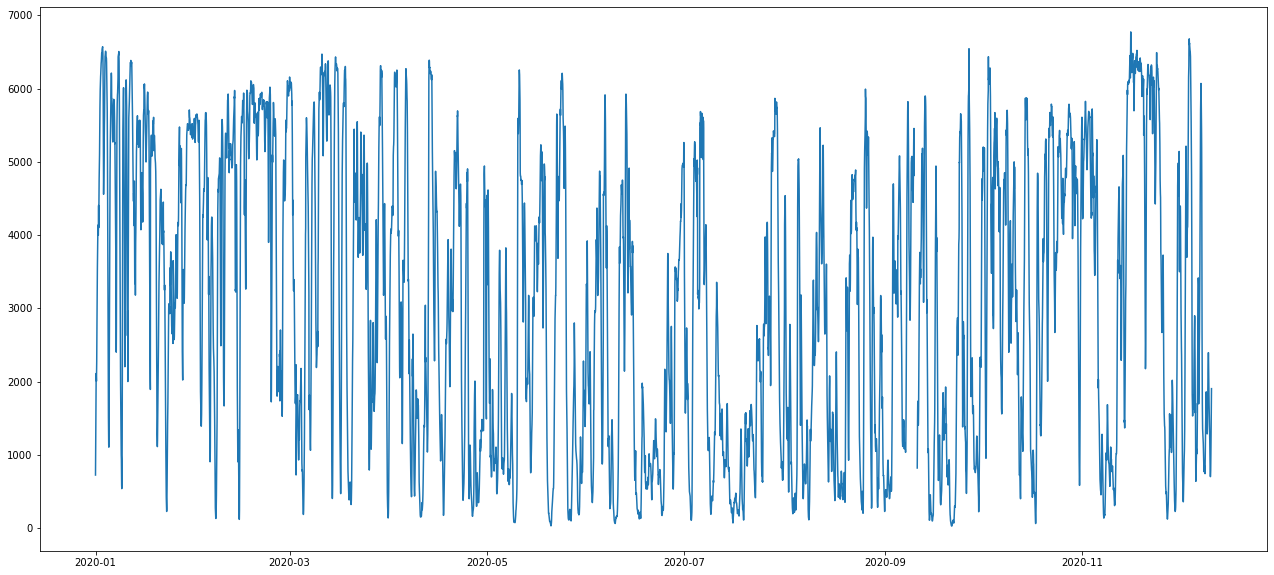

In [7]:
figure = plt.figure(figsize=(22,10))
plt.plot(df[['Generation - Wind Offshore  [MW] Day Ahead/ BZN|DE-LU']], label = 'Gen Wind Offshore')

In [8]:
df[['Wind Offshore  - Actual Aggregated [MW]']].iloc[:-10]

,Wind Offshore - Actual Aggregated [MW]
time_column,
2020-01-01 00:00:00,531.250000
2020-01-01 01:00:00,1161.500000
2020-01-01 02:00:00,1659.250000
2020-01-01 03:00:00,2057.000000
2020-01-01 04:00:00,2290.750000
...,...
2020-12-10 09:00:00,1237.500000
2020-12-10 10:00:00,1128.666667
2020-12-10 11:00:00,NaN


In [9]:
df[['Generation - Wind Offshore  [MW] Day Ahead/ BZN|DE-LU']].iloc[-15:]

,Generation - Wind Offshore [MW] Day Ahead/ BZN|DE-LU
time_column,
2020-12-10 09:00:00,1362.00
2020-12-10 10:00:00,1208.75
2020-12-10 11:00:00,1041.75
2020-12-10 12:00:00,900.25
2020-12-10 13:00:00,790.75
2020-12-10 14:00:00,715.00
2020-12-10 15:00:00,701.75
2020-12-10 16:00:00,723.75
2020-12-10 17:00:00,781.50


In [10]:
# the missing values in the Actuals can be replaced by the generation forecast
# the last date of the actuals column just before the missing values can be replaced with the values from the
# last date of the forecast columns

for column_x, forecast_column_x in zip(actual_columns, forecast_columns):
    date_before_nan = df[column_x].dropna().index[-1:][0]
    df[column_x][date_before_nan:] = df[forecast_column_x][date_before_nan:].values
    

# Now we can drop the forecast columns
df = df.drop(columns = forecast_columns)

# Add the weekday feature
# Add the weekend feature
week_days = df.index.weekday

df['week_days'] = week_days

In [11]:
# Handling missing values
# We will use cubic interpolation to fill the missing values
'''
Cubic interpolation
If the values of a function f(x) and its derivative are known at x=0 and x=1, then the function can be interpolated on the interval [0,1] using a third degree polynomial. This is called cubic interpolation. The formula of this polynomial can be easily derived.

A third degree polynomial and its derivative:

f(x) = ax^3 + bx^2 + cx + d
'''
df = df.interpolate(method='cubic')
df_copy = df.copy()

In [12]:
### Stationarity check
### The stationarity check is the null hypothesis test which checks whether the underlying time-series is stationary or not
### The following code has been adapted from the website https://machinelearningmastery.com/time-series-data-stationary-python/

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        
# Run test on the time series
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Day-ahead Price [EUR/MWh]" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9978
 No. Lags Chosen       = 29
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Solar  - Actual Aggregated [MW]" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1845
 No. Lags Chosen       = 27
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0007. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Wind Offshore  - Actual Aggregated [MW]" 
    --------------------------------------------

In [13]:
'''
Let us do another stationarity test using KPSS
'''
def kpss_test(series,name='', **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Test on:',name)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

        
# Run test on the time series
for name, column in df.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

KPSS Test on: Day-ahead Price [EUR/MWh]
KPSS Statistic: 6.254856891893076
p-value: 0.01
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on: Solar  - Actual Aggregated [MW]
KPSS Statistic: 3.5704848423058397
p-value: 0.01
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on: Wind Offshore  - Actual Aggregated [MW]
KPSS Statistic: 1.8847572838277113
p-value: 0.01
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on: Wind Onshore  - Actual Aggregated [MW]
KPSS Statistic: 3.88598334268354
p-value: 0.01
num lags: 37
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on: Actual Total Load [MW] - BZN|DE-LU
KPSS Statistic: 2.16848475717988
p-value: 0.01
num lags: 

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/rohankum

#### From the KPSS Test we can see that the test yields all the time series as non-stationary while the Adfuller test was opposite.
'''
Since ts cannot be stationary for the VAR, therefore, we will stationarize the TS before making it ready for VAR
'''

In [14]:
df = df.diff().dropna()

In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        
# Run test on the time series
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Day-ahead Price [EUR/MWh]" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.4722
 No. Lags Chosen       = 32
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Solar  - Actual Aggregated [MW]" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.5002
 No. Lags Chosen       = 26
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Wind Offshore  - Actual Aggregated [MW]" 
    ---------------------------------------------

In [16]:
df

,Day-ahead Price [EUR/MWh],Solar - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Actual Total Load [MW] - BZN|DE-LU,week_days
time_column,,,,,,
2020-01-01 01:00:00,-3.28,0.0,630.25,-214.00,-1157.25,0.0
2020-01-01 02:00:00,-2.05,0.0,497.75,-116.00,-796.25,0.0
2020-01-01 03:00:00,-4.23,0.0,397.75,-321.25,-1491.50,0.0
2020-01-01 04:00:00,-1.47,0.0,233.75,17.75,-49.50,0.0
2020-01-01 05:00:00,-0.71,0.0,-132.25,136.00,281.75,0.0
...,...,...,...,...,...,...
2020-12-10 19:00:00,-18.34,0.0,192.00,61.75,-1501.75,0.0
2020-12-10 20:00:00,-13.48,0.0,225.00,136.50,-4033.00,0.0
2020-12-10 21:00:00,-10.73,0.0,207.75,171.75,-3885.50,0.0


In [17]:
### Granger's Causation Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Day-ahead Price [EUR/MWh]_x,Solar - Actual Aggregated [MW]_x,Wind Offshore - Actual Aggregated [MW]_x,Wind Onshore - Actual Aggregated [MW]_x,Actual Total Load [MW] - BZN|DE-LU_x,week_days_x
Day-ahead Price [EUR/MWh]_y,1.0000,0.0000,0.0012,0.0000,0.0000,0.0000
Solar - Actual Aggregated [MW]_y,0.0000,1.0000,0.0002,0.0000,0.0000,0.8890
Wind Offshore - Actual Aggregated [MW]_y,0.0027,0.0000,1.0000,0.0000,0.0006,0.2440
Wind Onshore - Actual Aggregated [MW]_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.3161
Actual Total Load [MW] - BZN|DE-LU_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
week_days_y,0.0000,0.9994,0.0020,0.0398,0.0000,1.0000


In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(train_X, alpha=0.05):
    out  = coint_johansen(endog = df, det_order= -1, k_ar_diff = 50)
    d = {'0.90':0,'0.95':1,'0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length = 4): return str(val).ljust(length)
    
    print('Name :: Trace Test Stat > C(95%) => Signif \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col),' :: ', adjust(round(trace,2), 7),">", adjust(cvt, 8), ' => ',trace > cvt)
        
cointegration_test(df)

Name :: Trace Test Stat > C(95%) => Signif 
 ----------------------------------------
Day-ahead Price [EUR/MWh]  ::  1905.71 > 83.9383   =>  True
Solar  - Actual Aggregated [MW]  ::  1483.82 > 60.0627   =>  True
Wind Offshore  - Actual Aggregated [MW]  ::  1110.2  > 40.1749   =>  True
Wind Onshore  - Actual Aggregated [MW]  ::  764.25  > 24.2761   =>  True
Actual Total Load [MW] - BZN|DE-LU  ::  480.94  > 12.3212   =>  True
week_days  ::  206.7   > 4.1296    =>  True


In [19]:
'''
Selecting the right lag
We need to find the least AIC score and for me it looks 26th lag is optimal
'''


#Making a VAR model
from statsmodels.tsa.api import VAR
model = VECM(df, k_ar_diff = 48,coint_rank = 6)

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [20]:
'''
Rolling window forecast!
The dataset is broken into 5 months consecutively with tranining set containing 5 months and test set 24 hours ahead 
'''
def invert_transformation(data_train, df_forecast, second_diff = False):
    "Revert back the differencing to get the forecast to original scale"
    "Retrived from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/"
    df_fc = df_forecast.copy()
    columns = data_train.columns
    for col in columns:
        #Roll back 2nd diff
        #if second_diff:
        #    df_fc[str(col)+'_1d'] = (data_train[col].iloc[-1]-data_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        #Roll back 1st diff
        df_fc[str(col)+'_forecast'] = data_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

def rolling_window(data,window,shift):
    '''
    This will create a set of 5 momths in the training set and 5months + 24 hours in the test set
    '''
    partitions = []
    for i in range(window, len(data),shift):
        train = data.iloc[i-window:i]       #0-3600 = -3600 : 0
        test = data[i:i+24]                 # 0:24
        partitions.append([train, test])

    return partitions



features = list(range(0,len(df_copy.columns)))

dataset = rolling_window(df_copy,3600,24)

vecm_mae_list = []
vecm_rmse_list = []

for partition in dataset:

  # Training and Test dataset 
  train_set = partition[0] # the first in the list
  train_set_diff = train_set.diff().dropna()  
  train_set_diff = train_set_diff.loc[:,df_copy.columns]
  test_set = partition[1]  # the value to be predicted in the list

  # Forecast 
  vecm = VECM(df_copy, k_ar_diff = 26, coint_rank = 6).fit()
  vecm_fc = vecm.predict(steps = len(test_set)) # dynamic test set length will make sure that the shapes passed are matching

  vecm_fc_df = pd.DataFrame(vecm_fc, columns = test_set.loc[:,df.columns].columns, index = test_set.iloc[:,0].index)
  vecm_fc_df = invert_transformation(train_set.loc[:,df.columns], vecm_fc_df)
    
  vecm_mae_list.append(mean_absolute_error(test_set.iloc[:,0], vecm_fc_df.iloc[:,0]))
  vecm_rmse_list.append(np.sqrt(mean_squared_error(test_set.iloc[:,0], vecm_fc_df.iloc[:,0])))

print('Average MAE for VECM is:', np.array(vecm_mae_list).mean())
print('Average RMSE for VECM is:', np.array(vecm_rmse_list).mean())

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rohankumar/anaconda3/envs/thesis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: Va

Average MAE for VECM is: 20.142296702004554
Average RMSE for VECM is: 22.827954133690383


In [21]:
df_copy.iloc[-15:]

,Day-ahead Price [EUR/MWh],Solar - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Actual Total Load [MW] - BZN|DE-LU,week_days
time_column,,,,,,
2020-12-10 09:00:00,93.94,685.75,1237.50,1357.50,70396.75,3
2020-12-10 10:00:00,92.48,2254.00,1208.75,1265.75,70182.00,3
2020-12-10 11:00:00,92.99,3143.75,1041.75,1000.25,70869.75,3
2020-12-10 12:00:00,86.82,3311.25,900.25,921.75,70378.50,3
2020-12-10 13:00:00,93.10,2812.00,790.75,991.75,69797.00,3
2020-12-10 14:00:00,85.24,1779.75,715.00,1102.75,68765.50,3
2020-12-10 15:00:00,89.68,606.50,701.75,1356.75,68247.25,3
2020-12-10 16:00:00,101.00,35.50,723.75,1697.75,68851.25,3
2020-12-10 17:00:00,105.41,0.00,781.50,1994.25,70837.25,3
